## Problem 3 - Asset Pricing - Group Assignment

In [143]:
# Libraries we will need
# (same as the ones we use in Problem 1)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib as plt
import openpyxl as opl
import statistics as st
import scipy as sp

# Read data
portfolio = pd.read_csv('../Problem1/data/25_Portfolios_5x5.csv', parse_dates= True, index_col='DATE', infer_datetime_format=True)
portfolio.index = pd.to_datetime(portfolio.index, format="%Y%m")

# Calculate average returns

inv_df = pd.read_csv('Portfolios_Formed_on_INV.csv',  index_col = "DATE")
inv_df.index = pd.to_datetime(inv_df.index, format="%Y%m")

inv_df['RM'] = np.round((inv_df['Lo 30'] + inv_df['Med 40'] + inv_df['Hi 30'])/3,4)

risk_free = pd.read_csv('../Problem1/data/RF_Data.csv', index_col = "DATE")
risk_free.index = pd.to_datetime(risk_free.index, format = "%Y%m")


# Merge together
#df = pd.merge(left = portfolio, right = inv_df, how = 'inner', on = 'DATE')
df = pd.merge(left = inv_df, right = risk_free, how = "inner", on = "DATE")


# Excess returns

df["Lo 10"] = df["Lo 10"] - df["RF"]
df["2-Dec"] = df["2-Dec"] - df["RF"]
df["3-Dec"] = df["3-Dec"] - df["RF"]
df["4-Dec"] = df["4-Dec"] - df["RF"]
df["5-Dec"] = df["5-Dec"] - df["RF"]
df["6-Dec"] = df["6-Dec"] - df["RF"]
df["7-Dec"] = df["7-Dec"] - df["RF"]
df["8-Dec"] = df["8-Dec"] - df["RF"]
df["9-Dec"] = df["9-Dec"] - df["RF"]
df["Hi 10"] = df["Hi 10"] - df["RF"]
df["RM"] = df["RM"] - df["RF"]


In [144]:
# Regression dataset

reg_df = df[["RM","Lo 10", "2-Dec", "3-Dec", "4-Dec", "5-Dec", "6-Dec", "7-Dec", "8-Dec", "9-Dec", "Hi 10"]]
reg_df
# Estimate CAPM regression for each investment decile
import statsmodels.api as sm

output_df = pd.DataFrame(columns = ["var","alpha", "beta"])

#factors = sm.add_constant(df['RM'])
#all_results = {}
#mod = sm.OLS(df[reg_df.columns[2]], factors)
#res = mod.fit(cov_type="HC0")

for i in reg_df.columns:
    if(i != 'RM'):
        factors = sm.add_constant(reg_df['RM'])
        mod = sm.OLS(reg_df[i], factors)
        res = mod.fit(cov_type="HC0")
        aux_df = {"var": [i], "alpha": [res.params['const']], "beta": [res.params['RM']]}
        aux_df = pd.DataFrame(aux_df)
        output_df = output_df.append(aux_df)



0.005528461927867445


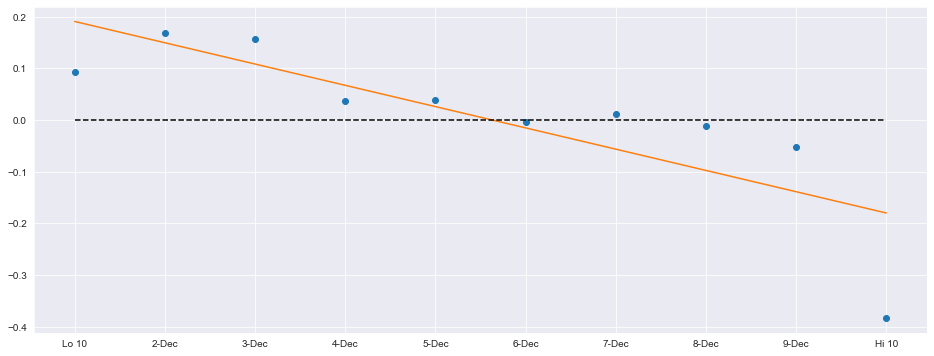

In [145]:
# Plot results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

fig = plt.figure(figsize=(16, 6))
fig = plt.plot(output_df['var'], output_df['alpha'], 'o')
#output_df['aux_seq'] = np.linspace(1,len(output_df), len(output_df))
output_df['seq'] = np.array([1,2,3,4,5,6,7,8,9,10])
m, b = np.polyfit(np.array(output_df['seq']), np.array(output_df['alpha']), 1) # Linear regression
output_df['line'] = m*output_df['seq'] + b
fig = plt.plot(output_df['var'], output_df['line'])
fig = plt.plot(np.repeat(0,10), linestyle = 'dashed', color = 'black')
print(np.mean(output_df['alpha']))


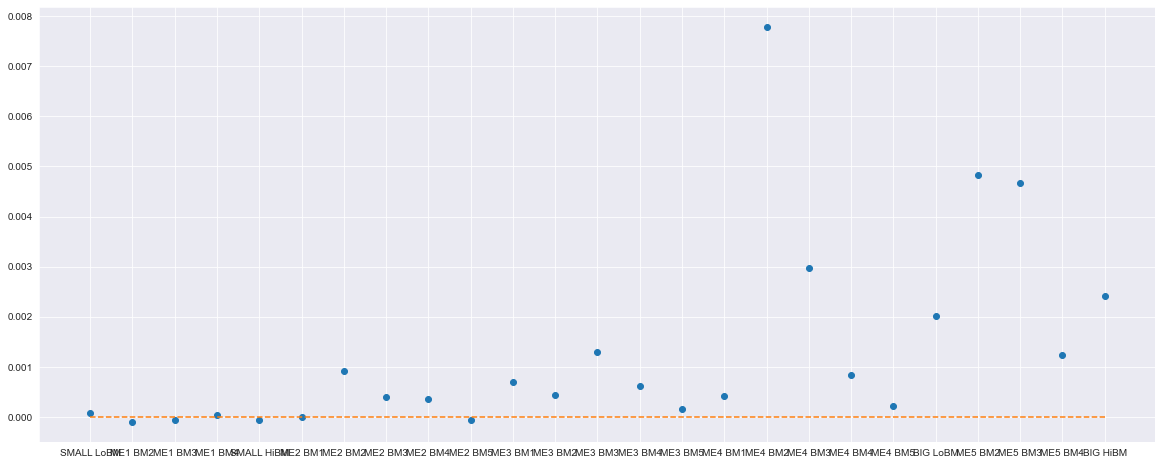

In [222]:
#

df['inv_factor'] = df['Lo 30'] - df['Hi 30']

# c) See Goyal. SKIP for now

# Calculate average market return

#portfolio['RM'] = portfolio.apply(np.mean, axis = 0) # Not necessary. Already in Fama-Frech data

factor_df = pd.read_csv("F-F_Research_Data_Factors.csv", index_col = "DATE")
factor_df.index = pd.to_datetime(factor_df.index, format= "%Y%m")

# Subtract RF on all columns

factor_df_adj = pd.merge(left = portfolio, right = factor_df['RF'], on = 'DATE', how = 'inner')

for i in factor_df_adj:
    if(i != 'RF'):
        factor_df_adj[i] = factor_df_adj[i] - factor_df_adj['RF']


# Run 2 regressions for every portfolio

factor_df_adj = pd.merge(left = factor_df_adj, right = factor_df[["RM", "SMB", "HML"]], on = 'DATE', how = 'inner')
factor_df_adj = pd.merge(left = factor_df_adj, right = df['inv_factor'], on = "DATE", how = "inner")
# Note that RM = Mkt-RF already

factors_ni = sm.add_constant(factor_df_adj[["RM","SMB","HML"]])
factors_i = sm.add_constant(factor_df_adj[["RM","SMB","HML","inv_factor"]])

df_outputs = pd.DataFrame(columns = ['portfolio','alpha_ni', 'rsq_ni','tstat_ni','rss_ni',
                                     'alpha_i', 'rsq_i','tstat_i','rss_i'])

df_aux_reg = factor_df_adj.drop(['RF','SMB','HML','inv_factor','RM'], axis = 1)
#df_aux_reg.columns

for i in df_aux_reg.columns:
    mod_ni = sm.OLS(factor_df_adj[i], factors_ni)
    res_ni = mod_ni.fit(cov_type="HC0")
    mod_i = sm.OLS(factor_df_adj[i], factors_i)
    res_i = mod_i.fit(cov_type="HC0")
    aux_df = {'portfolio': [i],
                'alpha_ni' : [res_ni.params.loc['const']],
                'rsq_ni' : [res_ni.rsquared_adj],
                'tstat_ni' : [res_ni.tvalues[0]],
                'rss_ni' : [res_ni.ssr],
                'alpha_i' : [res_i.params.loc['const']],
                'rsq_i' : [res_i.rsquared_adj],
                'tstat_i' : [res_i.tvalues[0]],
                'rss_i' : [res_i.ssr]}
    aux_df = pd.DataFrame(aux_df)
    df_outputs = df_outputs.append(aux_df)

# TEST
df_outputs['rsq_diff'] = df_outputs['rsq_i'] - df_outputs['rsq_ni']

fig2 = plt.figure(figsize=(20, 8))
fig2 = plt.plot(df_outputs['portfolio'], df_outputs['rsq_diff'], 'o')
fig2 = plt.plot(np.repeat(0,25), linestyle = 'dashed')


In [232]:
# GRS test
from scipy.stats import chi2
# Sharpe ratio for GSR test

# Add back risk free rate
factor_df['RMpRF'] = factor_df['RM'] + factor_df['RF']
sharpe_mkt = (np.mean(factor_df['RM'])/np.std(factor_df['RMpRF']))

#GSR_stat = T*alpha.T*np.inv(sigma)*alpha/(1 + Sharpe^2)

df_outputs['GRS_i'] = len(factor_df_adj)*(np.power(df_outputs['alpha_i'],2))*np.power(df_outputs['rss_i'],-1)/(1+np.power(sharpe_mkt,2))
df_outputs['GRS_ni'] = len(factor_df_adj)*(np.power(df_outputs['alpha_ni'],2))*np.power(df_outputs['rss_ni'],-1)/(1+np.power(sharpe_mkt,2))


In [237]:
chi2.cdf(df = 3, x = 2)
df_outputs['chi_i'] = chi2.cdf(df = 4, x = df_outputs['GRS_i'])
df_outputs['chi_ni'] = chi2.cdf(df = 3, x = df_outputs['GRS_ni'])

df_outputs[['chi_i','chi_ni']]

,chi_i,chi_ni
0,1.745069e-04,2.008527e-03
0,2.162885e-09,3.709475e-07
0,5.763175e-08,4.725293e-06
0,1.943102e-05,3.393371e-04
0,6.362987e-06,1.705424e-04
0,1.813868e-05,3.266787e-04
0,8.832245e-11,8.088880e-07
0,9.668694e-08,1.177799e-05
0,1.454710e-07,1.568853e-05
0,3.218041e-10,6.356533e-08
